# Book 4: Modelling & Evaluation Part 2 - Sentiment Analysis

---

This project consist of 4 separate notebook:

1. Book 1 - ProblemStatement & DataCollection 
2. Book 2 - Preprocessing
3. Book 3 - Modelling & Evaluation Part 1 - Text Classification
4. Book 4 - Modelling & Evaluation Part 2 - Sentiment Analysis

- This book focus in identifying the sentiment of the post.
- From the sentiment, we are trying to identify which words have a positive or a negative sentiment to guide us in solving our problem statement.

## 1.0 Libraries Import
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


## 2.0 Data Import

---

In [2]:
main_df = pd.read_csv('./data/main_data.csv')
main_df.shape

(19241, 12)

## 3.0 Sentiment Analysis using Pre-Trained Model from HuggingFace

### 3.1 Pre-Trained Model Assessment

- 300 rows of data of equal response variable weightage was randomly selected and manually annotated with the sentiment value of <code>"NEU", "NEG" & "POS"</code>
- Two pre-trained model were assessed:
    - <code>finiteautomata/bertweet-base-sentiment-analysis</code>
    - <code>cardiffnlp/twitter-roberta-base-sentiment</code>
- The annotated data will be use to assess the pre-trained model by measuring the accuracy.


In [3]:
# Sampled 300 data (150 post each from each subreddit) to carry out manual sentiment annotation
# ---------------------------------------------------------------------------------------------
# sampled_df = main_df.loc[main_df['subreddit']==0,['index','subreddit','post_demojized_only']].sample(150)
# sampled_df = pd.concat([sampled_df,main_df.loc[main_df['subreddit']==1,['index','subreddit','post_demojized_only']].sample(150)],join='inner')
# sampled_df['manual_sentiment'] = np.nan
# sampled_df.to_csv('./data/manual_sentiment_annotated_data.csv',index=False)


In [4]:
# Create a function to run different types of text classification model for sentiment analysis
def classifier_model_accuracy_test(data_dir,model,sentiment_label,annotated=False,max_length=None):
    # Read annotated data
    df = pd.read_csv(data_dir)
    
    # Initialize huggingface classifier
    classifier = pipeline("sentiment-analysis",
                        model=model)
    
    # Prepare data for classification
    sequence_to_classify = list(df['post_demojized_only'])
    
    # candidate_labels = ['dc','marvel']
    sentiment_result = classifier(sequence_to_classify,
                                  truncation = True,
                                  max_length = max_length)
    
    # Create dataframe from result
    sentiment_df = pd.DataFrame(sentiment_result)
    
    # Generalize result naming convention
    sentiment_df['label'] = sentiment_df['label'].map({sentiment_label[0]:"NEG",sentiment_label[1]:"NEU",sentiment_label[2]:"POS"})
       
    # Compare manual and machine generated results
    # If annotated is true, we are testing our manually labelled data set
    if annotated == True:
        # Add post, subreddit and manual sentiment features into dataframe
        sentiment_df['post_demojized_only'] =  df['post_demojized_only'].reset_index(drop=True)
        sentiment_df.insert(0,'subreddit',df['subreddit'])
        sentiment_df.insert(1,'manual_sentiment',df['manual_sentiment'])
        sentiment_df['comparison_result'] = np.where(sentiment_df['manual_sentiment']==sentiment_df['label'],1,0)
    
        # Calculate model accuracy
        model_accuracy = sentiment_df['comparison_result'].sum()/sentiment_df.shape[0]
        print(f"Model accuracy: {model_accuracy}")
        return model_accuracy, sentiment_df
    else:
        return sentiment_df

# Run "classifier_model_accuracy_test" function and then convert result into a dataframe
def run_sentiment_analysis(data_dir,model,sentiment_label,max_length=None):
    sentimentized_df = classifier_model_accuracy_test(data_dir=data_dir,
                                model=model,
                                sentiment_label=sentiment_label,
                                annotated=False,
                                max_length=max_length)
    
    sentiment_main_df = main_df.copy()
    sentiment_main_df['sentiment'] = sentimentized_df['label']
    sentiment_main_df['sentiment_score'] = sentimentized_df['score']
    return sentiment_main_df


### 3.2 Post-Assessment Result
- <code>"cardiffnlp/twitter-roberta-base-sentiment"</code> performed better than the other model.
- The model has an accuracy of 75.6% in classifying the post to the right sentiment.

In [67]:
classifier_model_accuracy_test(data_dir="./data/manual_sentiment_annotated_data.csv",
                                model="finiteautomata/bertweet-base-sentiment-analysis",
                                sentiment_label=['NEG','NEU','POS'],
                                annotated=True)

Model accuracy: 0.7333333333333333


In [66]:
classifier_model_accuracy_test(data_dir="./data/manual_sentiment_annotated_data.csv",
                                model="cardiffnlp/twitter-roberta-base-sentiment",
                                sentiment_label=['LABEL_0','LABEL_1','LABEL_2'],
                                annotated=True,
                                max_length= 512)

Model accuracy: 0.7566666666666667


## 4.0 Actual Sentimental Analysis Execution

In [5]:
# Run analysis
cardiffnlp_df = run_sentiment_analysis( data_dir="./data/main_data.csv",
                        model="cardiffnlp/twitter-roberta-base-sentiment",
                        sentiment_label=['LABEL_0','LABEL_1','LABEL_2'],
                        max_length=512)


In [6]:
# Save result into a csv file
pd.DataFrame.to_csv(cardiffnlp_df,'./data/sentiment_result_cardinffnlp_twitter_roberta_base_sentiment.csv',index=False)


## 5.0 Post-Result Analysis

---

In [29]:
# Function to find the top words positive and negative words of different ngram_range
def top_words_sentiment(df,ngram_range,pos_label,neg_label,subreddit,post):
    cvec = CountVectorizer(ngram_range=ngram_range)
    
    # extract top negative word
    cvec_neg_data = cvec.fit_transform(df.loc[(df['sentiment']==neg_label) & (df['subreddit']==subreddit)][post])
    cvec_neg_df = pd.DataFrame(cvec_neg_data.todense(),columns=cvec.get_feature_names())
    cvec_neg_df = pd.DataFrame(cvec_neg_df.sum().T.sort_values(ascending=False).head(10),columns=['freq'])    
    
    # extract top positive word
    cvec_pos_data = cvec.fit_transform(df.loc[(df['sentiment']==pos_label) & (df['subreddit']==subreddit)][post])
    cvec_pos_df = pd.DataFrame(cvec_pos_data.todense(),columns=cvec.get_feature_names())
    cvec_pos_df = pd.DataFrame(cvec_pos_df.sum().T.sort_values(ascending=False).head(10),columns=['freq'])

    return cvec_neg_df, cvec_pos_df

# plot barplot to show top 15 positive and negative words
def barplot_top_word(neg_df,pos_df,subreddit):
    fig, axs = plt.subplots(1, 2, figsize=(22,7))
    if subreddit ==0:      
        axs[0].title.set_text('Top 15 Words with Negative Sentiment in r/DC_Cinematic')
        axs[1].title.set_text('Top 15 Words with Positive Sentiment in r/DC_Cinematic')
    else:
        axs[0].title.set_text('Top 15 Words with Negative Sentiment in r/marvelstudios')
        axs[1].title.set_text('Top 15 Words with Positive Sentiment in r/marvelstudios')
                
    sns.barplot(y = neg_df.index,x = neg_df['freq'],ax = axs[0])
    sns.barplot(y = pos_df.index,x = pos_df['freq'],ax = axs[1])
    plt.show();
    return

# plot histogram of neutral, negative & positive post
def histplot_sentiment_score(df):
    # extract rows from r/marvelstudios
    marvel_sentiment = df.loc[df['subreddit']==1,:]
    # extract rows from r/DC_Cinematics
    dc_sentiment = df.loc[df['subreddit']==0,:]
    
    # Reorder category
    marvel_sentiment['sentiment'] = pd.Categorical(marvel_sentiment['sentiment'], ['NEU','NEG','POS'])    
    dc_sentiment['sentiment'] = pd.Categorical(dc_sentiment['sentiment'], ['NEU','NEG','POS'])
    
    # Plot histogram
    fig, axs = plt.subplots(1, 2, figsize=(22,7))
    axs[0].title.set_text('Sentiment Score r/DC_Cinematic')
    axs[1].title.set_text('Sentiment Score r/marvelstudios')
    sns.histplot(data = dc_sentiment, x = 'sentiment',ax = axs[0])
    sns.histplot(data = marvel_sentiment, x = 'sentiment',ax = axs[1])
    plt.show();

### 5.1 Import Sentiment Analysis Result

In [30]:
sentiment_result_df = pd.read_csv('./data/sentiment_result_cardinffnlp_twitter_roberta_base_sentiment.csv')
sentiment_result_df.head(2)

,index,subreddit,num_comments,created_utc,author,title_word_count,title_length,post,post_port_stemmed,post_snow_stemmed,post_unstemmed,post_demojized_only,sentiment,sentiment_score
0,0,1,0,1655815616,AlknA24,15,68,Can we agree that out of all the marvel movies...,agre marvel movi two make top,agre marvel movi two make top,agree marvel movies two make top,can we agree that out of all the marvel movies...,POS,0.851513
1,1,1,0,1655815581,SteveHarrington2025,6,36,Captain America Fan Film Fight Scene,captain america fan film fight scene,captain america fan film fight scene,captain america fan film fight scene,captain america fan film fight scene,NEU,0.876559


### 5.2 Sentiment Score Distribution

- Most of the post have a neutral sentiment, which was also observed when the manually labelling of data was done

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_10732\1397864744.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marvel_sentiment['sentiment'] = pd.Categorical(marvel_sentiment['sentiment'], ['NEU','NEG','POS'])
C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_10732\1397864744.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_sentiment['sentiment'] = pd.Categorical(dc_sentiment['sentiment'], ['NEU','NEG','POS'])


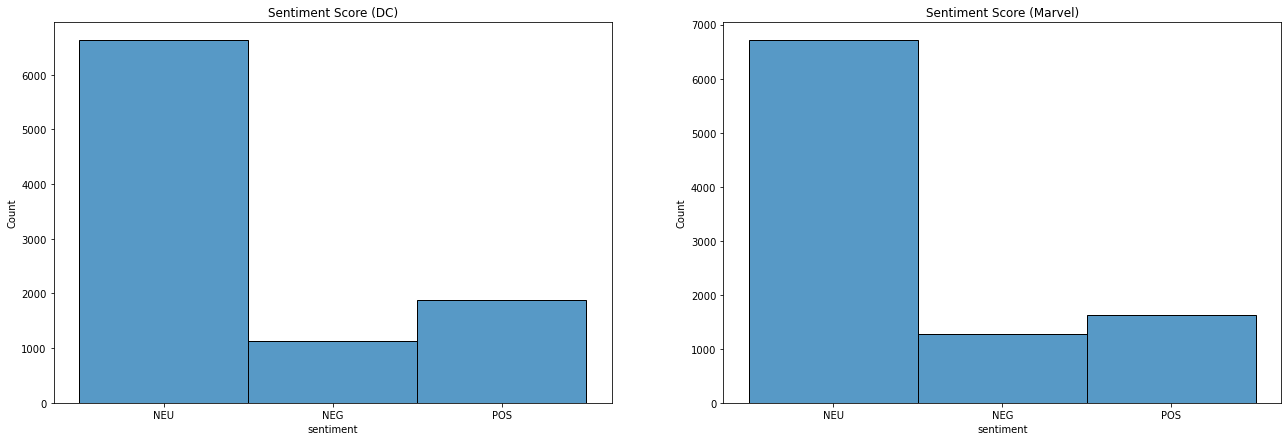

In [31]:
histplot_sentiment_score(sentiment_result_df)

### 5.3 Top Positive and Negative Words in r/DC_Cinematic 

- Phrases with negative sentiments (and no positive sentiments) should be avoided for product releases/marketing.
- Certain characters and actors under words with negative sentiments are involved in serious legal/moral issues and should be avoided.


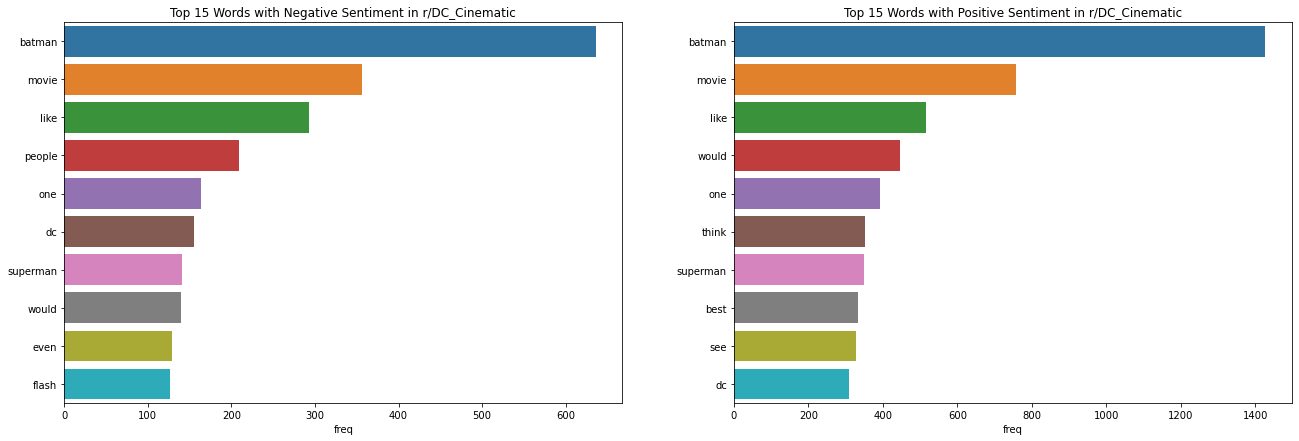

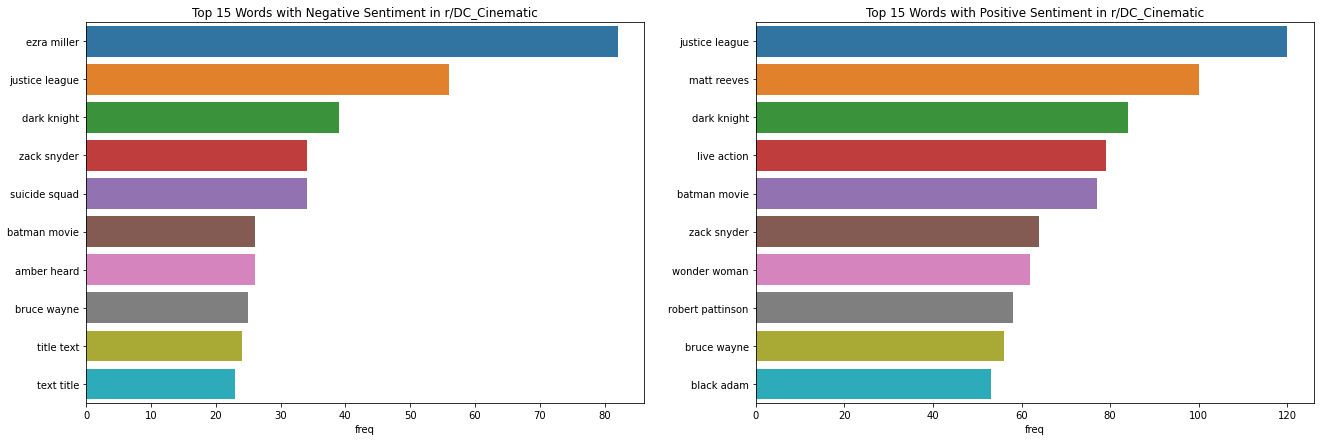

In [32]:
neg_uni_dc, pos_uni_dc = top_words_sentiment(sentiment_result_df,(1,1),'POS','NEG',0,'post_unstemmed')
neg_bi_dc, pos_bi_dc = top_words_sentiment(sentiment_result_df,(2,2),'POS','NEG',0,'post_unstemmed')

barplot_top_word(neg_uni_dc, pos_uni_dc,0)
barplot_top_word(neg_bi_dc, pos_bi_dc,0)

### 5.4 Top Positive and Negative Words in r/marvelstudios 

- There’s some overlap between top words with negative and positive sentiment 
- This is likely because the most popular characters/concepts/movies are likely to have a sizable group of fans and haters  


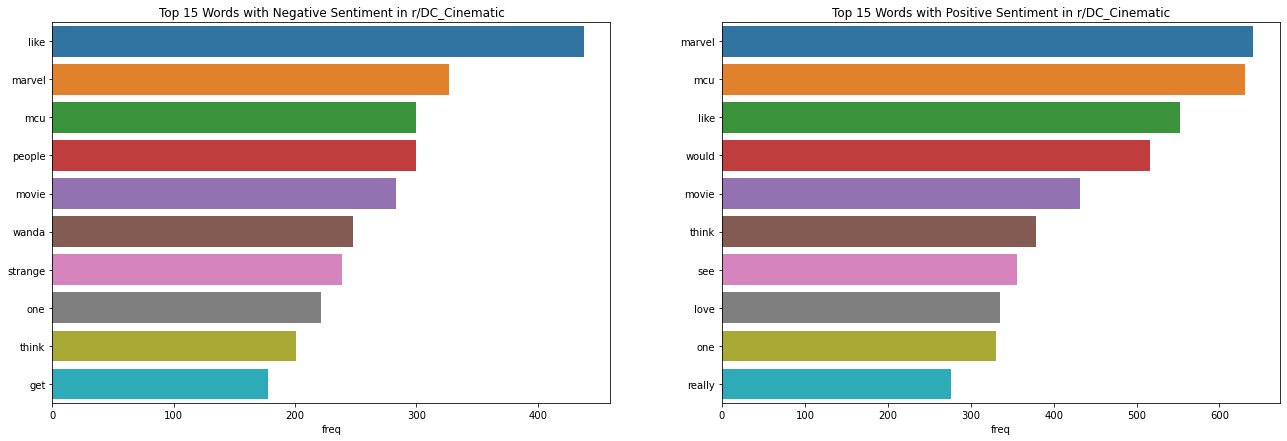

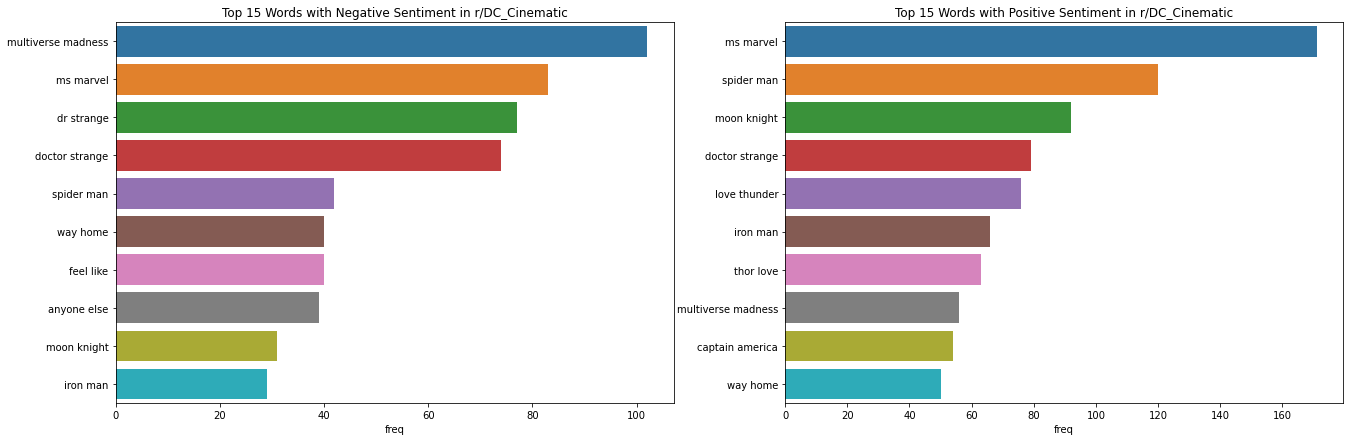

In [33]:
neg_uni_marvel, pos_uni_marvel = top_words_sentiment(sentiment_result_df,(1,1),'POS','NEG',1,'post_unstemmed')
neg_bi_marvel, pos_bi_marvel = top_words_sentiment(sentiment_result_df,(2,2),'POS','NEG',1,'post_unstemmed')

barplot_top_word(neg_uni_marvel, pos_uni_marvel,0)
barplot_top_word(neg_bi_marvel, pos_bi_marvel,0)

## 6.0 Conclusion

---

1. The model is able to successfully classify Reddit posts as r/DC_Cinematic & r/marvelstudios content, possible future applications include:
    - Classify data from other non-Reddit sources as Marvel/DC.
    - Can be used to to determine popularity/public interest in each brand.
    - Other downstream analysis e.g. sentiment analysis.

2. Key findings from sentiment analysis:
    - Able to identify most disccused superhero characters
        - Marvel: Ironman, Spiderman, Thor & Doctor Strange
        - DC: Batman, Superman, Wonder Woman & Joker
    - Key characters to avoid due to negative sentiment:
        - DC: Amber Heard & Ezra Miller 
    - Data could be utilized to develop toys and marketing initiatives:

---

# End of Book 4